# Imports

In [1]:
import os

os.chdir("/home/ivanr/git/document_information_extraction/")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

In [3]:
from src.data.wikipedia.wiki_data_base import retrieve_query

# Statics

In [4]:
from src.data.data_statics import SQL_WIKI_DUMP,TEMP_DB

# Read data

In [35]:
query = """
    SELECT  ar.pageid
           ,ar.title
           ,ar.summary_word_count
           ,ar.body_word_count
           ,nov.novelty_tokens
           ,nov.novelty_bigrams
           ,nov.novelty_trigrams
           ,sm.semantic_similarity
           
    FROM wiki_article_novelty nov
    INNER JOIN article_level_info ar
        ON ar.pageid=nov.pageid
    INNER JOIN wiki_article_cosine_similarity sm
        ON ar.pageid=sm.pageid
"""

In [ ]:
wiki_info_df = retrieve_query(query, out_f=SQL_WIKI_DUMP)
wiki_info_df = pd.DataFrame(
    wiki_info_df,
    columns=[
        "pageid",
        "title",
        "summary_word_count",
        "body_word_count",
        "novelty_tokens",
        "novelty_bigrams",
        "novelty_trigrams",
        "semantic_similarity"
    ],
)

In [ ]:
len(wiki_info_df)
# 1424051

# Evaluate distribution

In [8]:
wiki_info_df[["novelty_tokens", "novelty_bigrams", "novelty_trigrams",]] = wiki_info_df[
    ["novelty_tokens", "novelty_bigrams", "novelty_trigrams"]
].astype(float)

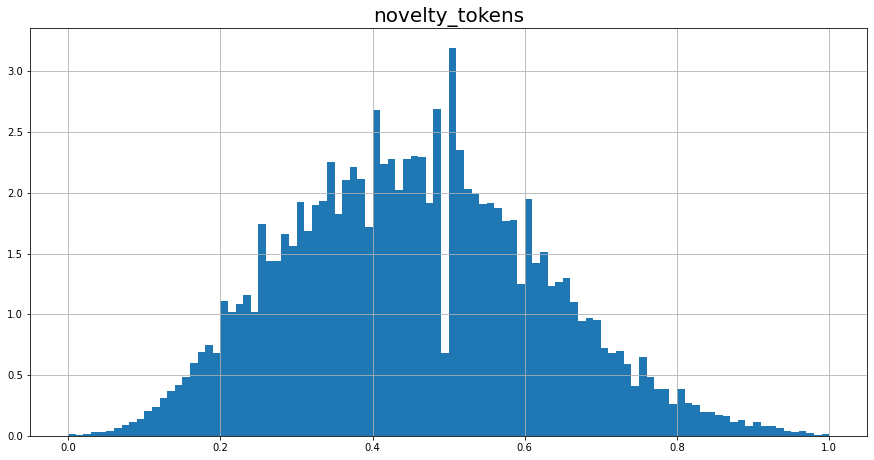

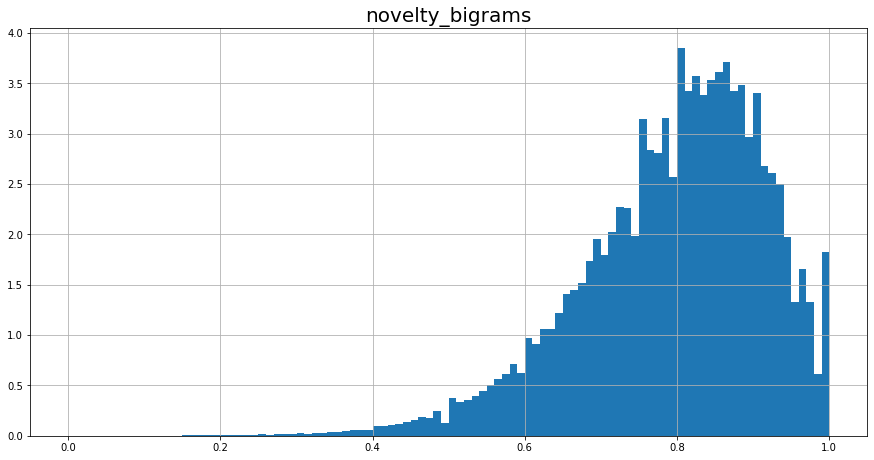

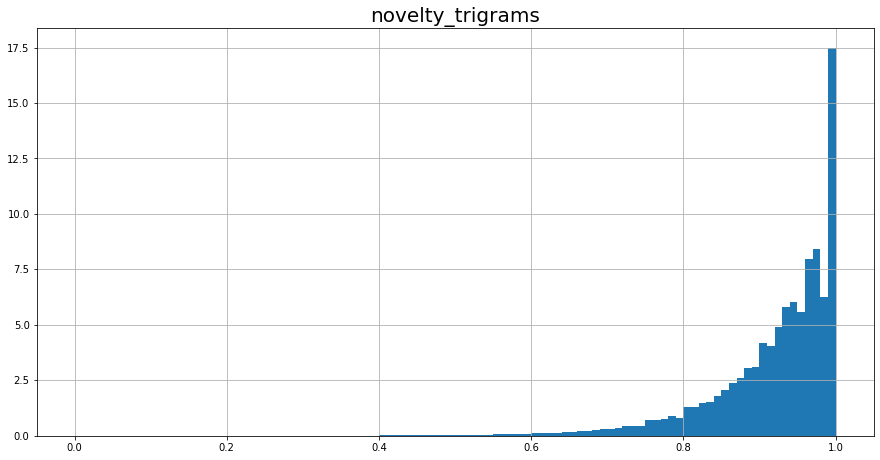

In [9]:
for var in ["novelty_tokens", "novelty_bigrams", "novelty_trigrams"]:
    plt.figure(figsize=(15, 7.5))
    plt.title(var, fontsize=20)
    novelty_df[var].hist(bins=100, density=True)
    plt.show()

In [10]:
novelty_df.describe()

,pageid,novelty_tokens,novelty_bigrams,novelty_trigrams
count,1.424051e+06,1.424051e+06,1.424051e+06,1.424051e+06
mean,2.515004e+07,4.563613e-01,7.949752e-01,9.192736e-01
std,2.129883e+07,1.661923e-01,1.212887e-01,8.571314e-02
min,1.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.582285e+06,3.333333e-01,7.241379e-01,8.863636e-01
50%,2.107890e+07,4.509804e-01,8.125000e-01,9.431818e-01
75%,4.282306e+07,5.714286e-01,8.837209e-01,9.782609e-01
max,6.876322e+07,1.000000e+00,1.000000e+00,1.000000e+00


# Semantic similarity

In [26]:
query = """
    SELECT *
    FROM wiki_article_cosine_similarity
"""

In [27]:
semantic_sim_df = retrieve_query(query, out_f= SQL_WIKI_DUMP)
semantic_sim_df = pd.DataFrame(
    semantic_sim_df,
    columns=["pageid", "semantic_similarity"],
)

In [29]:
len(semantic_sim_df) - len(novelty_df)

0

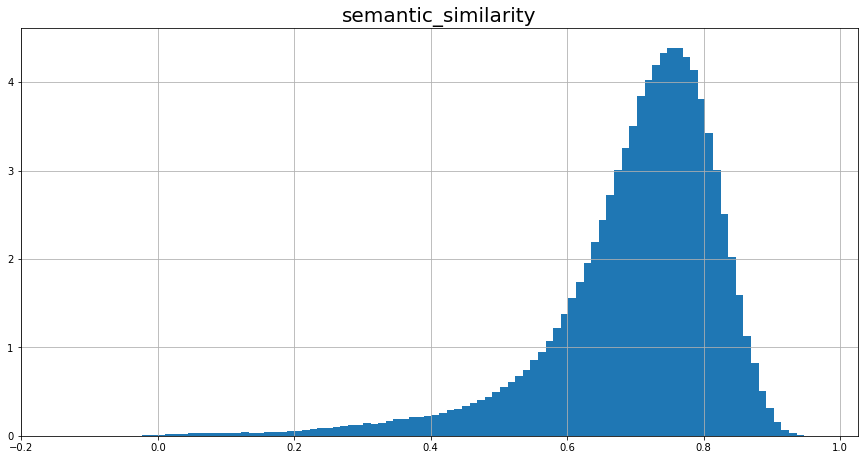

In [18]:
plt.figure(figsize=(15, 7.5))
plt.title("semantic_similarity", fontsize=20)
semantic_sim_df["semantic_similarity"].hist(bins=100, density=True)
plt.show()

## Compare correlation

In [19]:
full_df = novelty_df.merge(semantic_sim_df)

In [20]:
full_df.describe()

,pageid,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
count,5.346560e+05,534656.000000,534656.000000,534656.000000,534656.000000
mean,3.639484e+06,0.457627,0.801983,0.927848,0.700130
std,3.133277e+06,0.157417,0.111212,0.076120,0.125492
min,1.200000e+01,0.000000,0.000000,0.000000,-0.145407
25%,9.520780e+05,0.343750,0.737500,0.899471,0.649774
50%,2.725392e+06,0.454545,0.818182,0.948718,0.725401
75%,5.818927e+06,0.566667,0.882353,0.979167,0.783319
max,1.124891e+07,1.000000,1.000000,1.000000,0.969945


In [21]:
for var in ["novelty_tokens", "novelty_bigrams", "novelty_trigrams"]:
    corr, pval = pearsonr(full_df["semantic_similarity"],full_df[var])
    print(f"{var} has a correlation of {corr:.3f} with p-value {pval:.3f}")

novelty_tokens has a correlation of -0.453 with p-value 0.000
novelty_bigrams has a correlation of -0.376 with p-value 0.000
novelty_trigrams has a correlation of -0.273 with p-value 0.000


In [22]:
import matplotlib.cm as cm
from matplotlib.colors import LogNorm


def plot_joint(data, x_label, y_label, bins=(100, 100)):

    x = data[x_label]
    y = data[y_label]
    ax1 = sns.jointplot(x=x, y=y)
    ax1.ax_joint.cla()
    plt.sca(ax1.ax_joint)

    plt.hist2d(x, y, bins=bins, cmap=cm.jet, norm=LogNorm())
    plt.xlabel(x_label, fontsize=13)
    plt.ylabel(y_label, fontsize=13)

    cbar_ax = ax1.fig.add_axes([1, 0.1, 0.03, 0.7])
    cb = plt.colorbar(cax=cbar_ax)
    cb.set_label(r"$\log_{10}$ density of points", fontsize=13)
        
    plt.show()

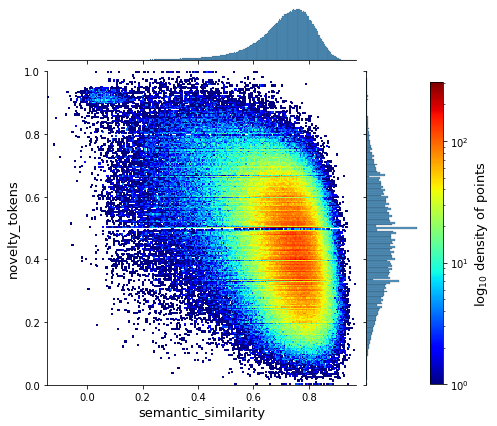

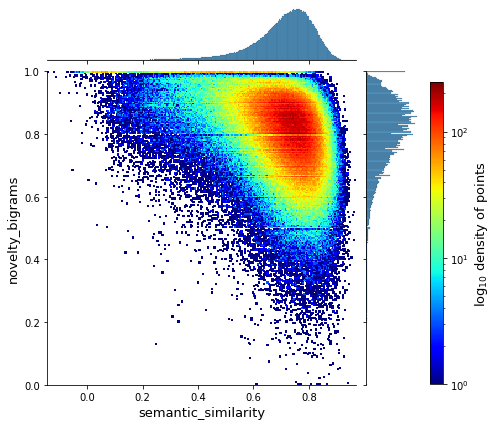

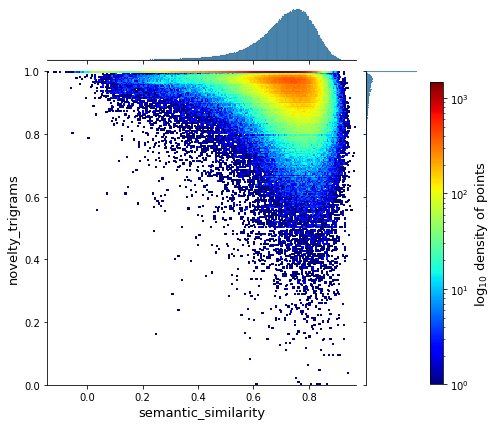

In [23]:
for var in ["novelty_tokens", "novelty_bigrams", "novelty_trigrams"]:
    plot_joint(
        full_df,
        "semantic_similarity",
        var,
        bins=(250, 250),
    )